# Compare generic genes

The goal of this notebook is to compare the generic genes found using 2 different recount2 template experiments.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import seaborn as sns
import pandas as pd
from ponyo import utils

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id1 = "SRP012656"
project_id2 = "SRP061689"

In [3]:
# Get data directory containing gene summary data
data_dir = os.path.join(base_dir, "human_general_analysis")

# Get gene ranking files
gene_ranking_filename1 = os.path.join(data_dir, f"generic_gene_summary_{project_id1}.tsv")
gene_ranking_filename2 = os.path.join(data_dir, f"generic_gene_summary_{project_id2}.tsv")

# Get template data
template_filename1 = os.path.join(data_dir, "data", f"processed_recount2_template_{project_id1}.tsv")
template_filename2 = os.path.join(data_dir, "data", f"processed_recount2_template_{project_id2}.tsv")

## Correlation between rankings

In [4]:
# Load gene ranking
gene_ranking_summary1 = pd.read_csv(gene_ranking_filename1, sep="\t", index_col=0, header=0)
gene_ranking_summary2 = pd.read_csv(gene_ranking_filename2, sep="\t", index_col=0, header=0)

In [5]:
# Get simulated ranking
gene_ranking1 = gene_ranking_summary1["Rank (simulated)"].rename("Rank 1")
gene_ranking2 = gene_ranking_summary2["Rank (simulated)"].rename("Rank 2")

# Combine ranking
gene_ranking_combined = pd.concat([gene_ranking1, gene_ranking2], axis=1)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [6]:
print(gene_ranking_combined.shape)
gene_ranking_combined.head()

(17755, 2)


Rank 1   Rank 2
A1BG      14536.0  10970.0
A1BG.AS1  10271.0   3665.0
A1CF      17086.0  15334.0
A2M       11905.0  11265.0
A2M.AS1   11908.0  12369.0

In [7]:
# Check for NAs
gene_ranking_combined[pd.isnull(gene_ranking_combined).any(axis=1)]

Empty DataFrame
Columns: [Rank 1, Rank 2]
Index: []

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


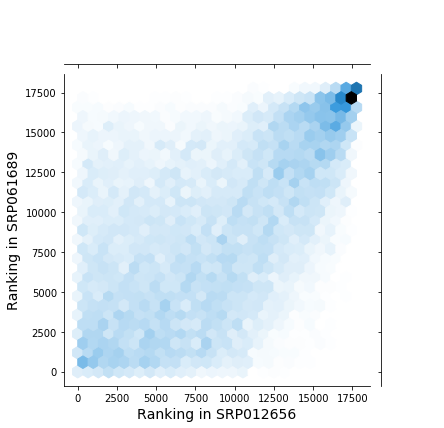

In [8]:
# Plot correlation between ranking
fig = sns.jointplot(
    data=gene_ranking_combined,
    x="Rank 1",
    y="Rank 2",
    kind="hex",
    marginal_kws={"color": "white"},
)

fig.set_axis_labels(
    f"Ranking in {project_id1}", f"Ranking in {project_id2}", fontsize=14, fontname="Verdana"
)

output_figure_filename = "concordance_between_recount2_templates.svg"
fig.savefig(
    output_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**

* Looks like there is good concordance between highly ranked genes (i.e. generic genes)
* In general, we expect that there are some genes that are generally generic (i.e. those that are concordant between these two experiments) and there are also genes that are generic within the given context of the specific experiment.

## Examine gene expression data

In [9]:
# Read expression data
template_1 = pd.read_csv(template_filename1, sep="\t", index_col=0, header=0)
template_2 = pd.read_csv(template_filename2, sep="\t", index_col=0, header=0)

In [10]:
# Get concordance genes
concordant_genes = list(gene_ranking_combined[(gene_ranking_combined["Rank 1"]>15000) &
                                         (gene_ranking_combined["Rank 2"]>15000)].index)

# Get disconcordant genes
discordant_genes = set(gene_ranking_combined.index).difference(concordant_genes)

Percent concordant genes with 0 expression in template 1: 0.05922270203578038
Percent nonzero concordant genes in template 1: 0.8389882788402221


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


[None, None]

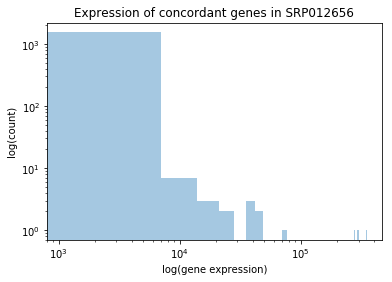

In [11]:
# Distribution of concordant genes in template experiment 1
template1_mean = template_1.mean()

print("Percent concordant genes with 0 expression in template 1:", 
      len(template1_mean[concordant_genes].loc[template1_mean[concordant_genes]==0])/len(template1_mean[concordant_genes]))

print("Percent nonzero concordant genes in template 1:", 
      len(template1_mean[concordant_genes].loc[(template1_mean[concordant_genes]>0) &
                                           (template1_mean[concordant_genes]<1000)])/len(template1_mean[concordant_genes]))

f1 = sns.distplot(template_1.mean()[concordant_genes], kde=False)
f1.set_title(f"Expression of concordant genes in {project_id1}")
f1.set_xlabel("log(gene expression)")
f1.set_ylabel("log(count)")
f1.set(xscale="log", yscale="log")

In [12]:
# Distribution of concordant genes in template experiment 2
template2_mean = template_2.mean()
print("Percent concordant genes with 0 expression in template 2:",
      len(template2_mean[concordant_genes].loc[template2_mean[concordant_genes]==0])/len(template2_mean[concordant_genes]))

print("Percent nonzero concordant genes in template 2:",
      len(template2_mean[concordant_genes].loc[(template2_mean[concordant_genes]>0) &
                                                (template2_mean[concordant_genes]<1000)])/len(template2_mean[concordant_genes]))

# There are more 0 expressed genes in this template experiment
f2 = sns.distplot(template_2.mean()[concordant_genes], kde=False)
f2.set_title(f"Expression of concordant genes in {project_id2}")
f2.set_xlabel("log(gene expression)")
f2.set_ylabel("log(count)")
f2.set(xscale="log", yscale="log")

Percent concordant genes with 0 expression in template 2: 0.40777297964219616
Percent nonzero concordant genes in template 2: 0.5293028994447871


[None, None]

In [13]:
# Distribution of discordant gense in template experiment 1
template1_mean = template_1.mean()

print("Percent discordant genes with 0 expression in template 1:", 
      len(template1_mean[discordant_genes].loc[template1_mean[discordant_genes]==0])/len(template1_mean[discordant_genes]))

print("Percent nonzero discordant genes in template 1:", 
      len(template1_mean[discordant_genes].loc[(template1_mean[discordant_genes]>0) &
                                           (template1_mean[discordant_genes]<1000)])/len(template1_mean[discordant_genes]))

print(len(template1_mean[discordant_genes].loc[template1_mean[discordant_genes]>0])/len(template1_mean[discordant_genes]))
f3 = sns.distplot(template_1.mean()[discordant_genes], kde=False)
f3.set_title(f"Expression of discordant genes in {project_id1}")
f3.set_xlabel("log(gene expression)")
f3.set_ylabel("log(count)")
f3.set(xscale="log", yscale="log")

Percent discordant genes with 0 expression in template 1: 0.004524606421222263
Percent nonzero discordant genes in template 1: 0.5705962563530432
0.962501549522747


[None, None]

Percent discordant genes with 0 expression in template 2: 0.059811578033965536
Percent nonzero discordant genes in template 2: 0.5682409817776125


[None, None]

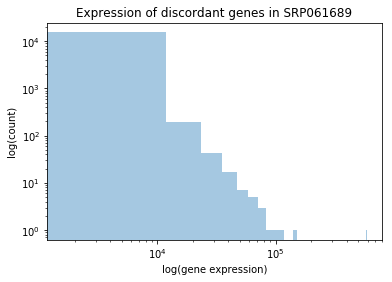

In [14]:
# Distribution of discordant genes in template experiment 2
template2_mean = template_2.mean()

print("Percent discordant genes with 0 expression in template 2:",
      len(template2_mean[discordant_genes].loc[template2_mean[discordant_genes]==0])/len(template2_mean[discordant_genes]))

print("Percent nonzero discordant genes in template 2:",
      len(template2_mean[discordant_genes].loc[(template2_mean[discordant_genes]>0) &
                                                (template2_mean[discordant_genes]<1000)])/len(template2_mean[discordant_genes]))

f4 = sns.distplot(template_2.mean()[discordant_genes], kde=False)
f4.set_title(f"Expression of discordant genes in {project_id2}")
f4.set_xlabel("log(gene expression)")
f4.set_ylabel("log(count)")
f4.set(xscale="log", yscale="log")

**Takeaway:**

Doesn't appear to be much of a difference between the distribution of average gene expression values for these two experiments. 

Theoretically, I would expect the scenario where a gene is lowly expressed in the context of template experiment 1 and therefore not found to be generic. But this same gene could be found to be generic in the context of template experiment 2 if it is more expressed. Its possible that differences in gene expression distribution can change which genes are found to be generic given that the simulation is producing experiments with a similar context. 

In this case, despite having similar gene expression distributions there are still many differences in gene ranking. This suggests to me that level of gene expression activity doesn't matter as much as the overall patterns perhaps. 

Overall we observe a slight shift showing that concordant genes are more lowly expressed compared to discordant genes, but most genes are still predominantly lowly gene expression. If most genes have expression levels very close to 0, then small fluctuations in the expression of some genes could lead to large changes in rank without changing the overall expression distribution. 